## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn. metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

### Read data into DFs

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [3]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

In [4]:
def strip_whitespace(df):
    
    # Remove trailing period if present
    df['pred'] = df['pred'].str.rstrip('.')

    return df

In [5]:
def replace_qmarks(df):
    
    # Convert "?" to missing values (NaN) in both dataframes
    df.replace("?", np.nan, inplace=True)

    return df

In [6]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
        
    return df

In [7]:
def preprocessing(df):

    df = data_to_str(df)
    df = strip_whitespace(df)
    df = replace_qmarks(df)
    df = data_to_int32(df)
    df = df.drop_duplicates()

    return df

In [8]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [9]:
chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

chart_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [41]:
def plot_prevalence_individual(df, categories, pred_col='pred'):
    sns.set_theme(style="whitegrid")

    teal_gradient = sns.color_palette("crest", 20) 

    for cat in categories:
        plt.figure(figsize=(10, 6))

        prevalence = df.groupby(cat)[pred_col].mean().sort_values()

        colors = teal_gradient[:len(prevalence)]

        ax = prevalence.plot(
            kind='bar',
            color=colors,
            edgecolor="black"
        )

        plt.title(
            f"Target Prevalence by {cat.replace('-', ' ').title()}",
            fontsize=20,
            fontweight='bold',
            color="#0B2D2F",            
            pad=15
        )
        plt.ylabel("Proportion with target = 1", fontsize=14, color="#0B2D2F")
        plt.xlabel(cat.replace('-', ' ').title(), fontsize=14, color="#0B2D2F")

        plt.xticks(rotation=45, ha='right', fontsize=14, color="#0B2D2F")
        plt.yticks(fontsize=14, color="#0B2D2F")

        ax.grid(axis='y', linestyle='--', alpha=0.5)

        sns.despine()

        plt.tight_layout()
        plt.show()

In [ ]:
cats = ['workclass','education','marital-status','occupation','relationship','hours-per-week']
plot_prevalence_individual(chart_df, cats)

## Recategorize the Categorical features into more meaningful groups

In [34]:
def category_remapping(df):

    copy_df = df.copy()
    
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    
    # Apply mapping and insert into dataframe
    copy_df.insert(2,'workclass-cat',copy_df['workclass'].map(workclass_mapping))
    
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    
    copy_df.insert(4,"education-cat",copy_df['education'].map(edu_mapping))
    
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    
    copy_df.insert(7,'marital-cat',copy_df['marital-status'].map(marital_mapping))

    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
    
        'Armed-Forces':'Military',
    
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    
    copy_df.insert(10,'occupation-cat',copy_df['occupation'].map(occupation_mapping))

    s = copy_df['native-country']
    
    native_imm_cat = (
        s.map({'United-States': 'Native'})         # US → Native, others → NaN
         .fillna('Immigrant')                     # non-US, non-missing → Immigrant
         .where(s.notna(), pd.NA)                 # where original was missing, keep NA
    )
    
    native_imm_cat.replace({pd.NA:np.nan}, inplace = True)
    
    copy_df.insert(18, 'native_imm_cat', native_imm_cat)

    hrs_bins = [0, 30, 40, 60, 100]
    hrs_labels = ['Part-Time', 'Underworked', 'Full-Time+', 'Overworked']
    
    copy_df['hours_bin'] = pd.cut(
        copy_df['hours-per-week'], 
        bins=hrs_bins, 
        labels=hrs_labels
    )

    # drop all adjusted categorical features in favor of their derived categories
    copy_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country','hours-per-week'], axis = 1, inplace = True)
    #copy_df.drop(['fnlwgt'], axis = 1, inplace = True)

    return copy_df

In [35]:
train_df = category_remapping(train_df)
test_df = category_remapping(test_df)

chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

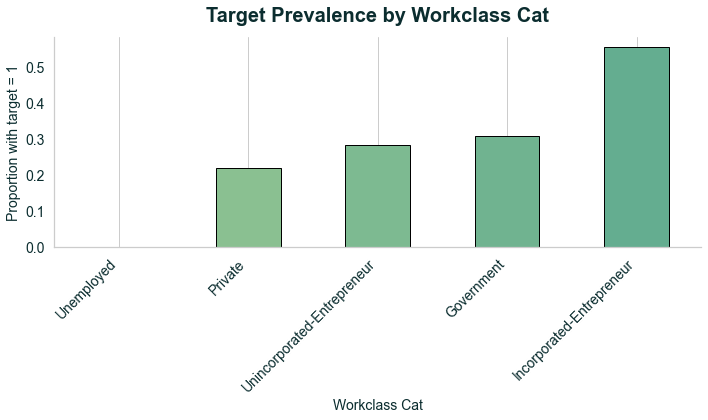

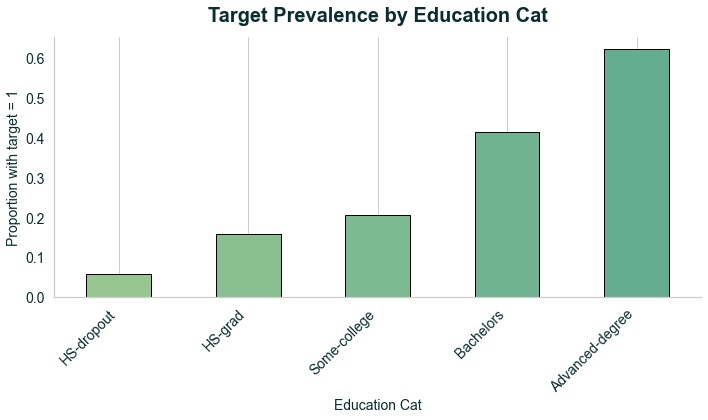

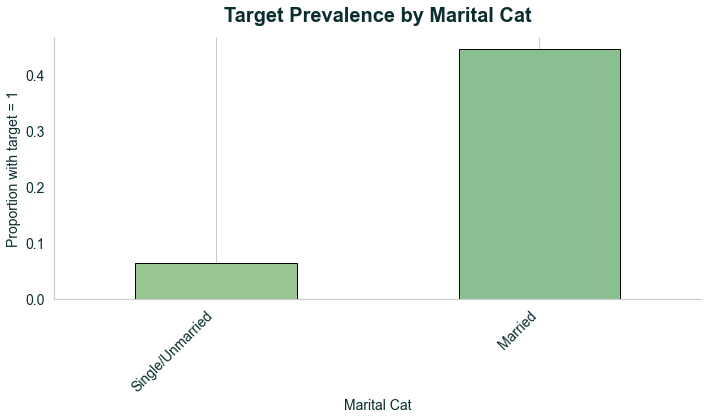

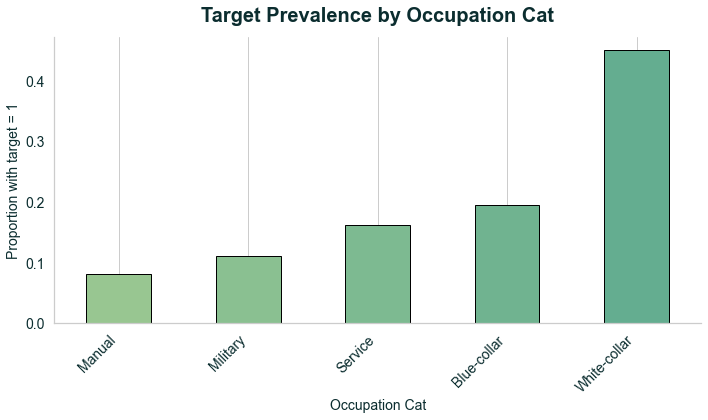

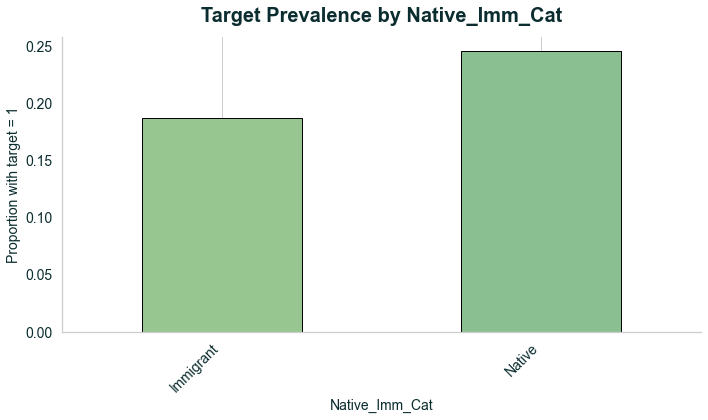

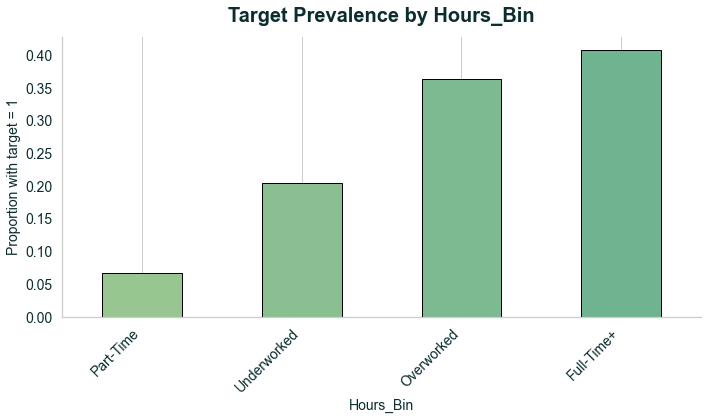

In [40]:
cats = ['workclass-cat','education-cat','marital-cat','occupation-cat','native_imm_cat','hours_bin']

plot_prevalence_individual(chart_df, cats)

## Missing Values

In [42]:
train_df.isna().sum()

age                  0
workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
native_imm_cat     582
pred                 0
hours_bin            0
dtype: int64

In [43]:
test_df.isna().sum()

age                 0
workclass-cat     963
education-cat       0
marital-cat         0
occupation-cat    966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
native_imm_cat    274
pred                0
hours_bin           0
dtype: int64

In [44]:
#Columns that have missing values
columns = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}
columns_test = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}

In [45]:
#Print only the columns that contain NA values
for col in columns:
    if train_df[col].isna().any():
        print(f"\n{col}")
        print(train_df[col].unique())


occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' nan 'Military']

workclass-cat
['Government' 'Unincorporated-Entrepreneur' 'Private' nan
 'Incorporated-Entrepreneur' 'Unemployed']

native_imm_cat
['Native' 'Immigrant' nan]


In [46]:
##### TRAIN
#Imputation: mode - 2
train_df_mode = train_df.copy()

for col in columns:
    train_df_mode[col] = train_df_mode[col].fillna(train_df_mode[col].mode()[0])

train_df_mode.isna().sum()

age               0
workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
native_imm_cat    0
pred              0
hours_bin         0
dtype: int64

In [47]:
#### TEST
#Imputation: mode - 2
test_df_mode = test_df.copy()

for col in columns_test:
    test_df_mode[col] = test_df_mode[col].fillna(test_df_mode[col].mode()[0])

test_df_mode.isna().sum()

age               0
workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
native_imm_cat    0
pred              0
hours_bin         0
dtype: int64

## Correlational Matrix

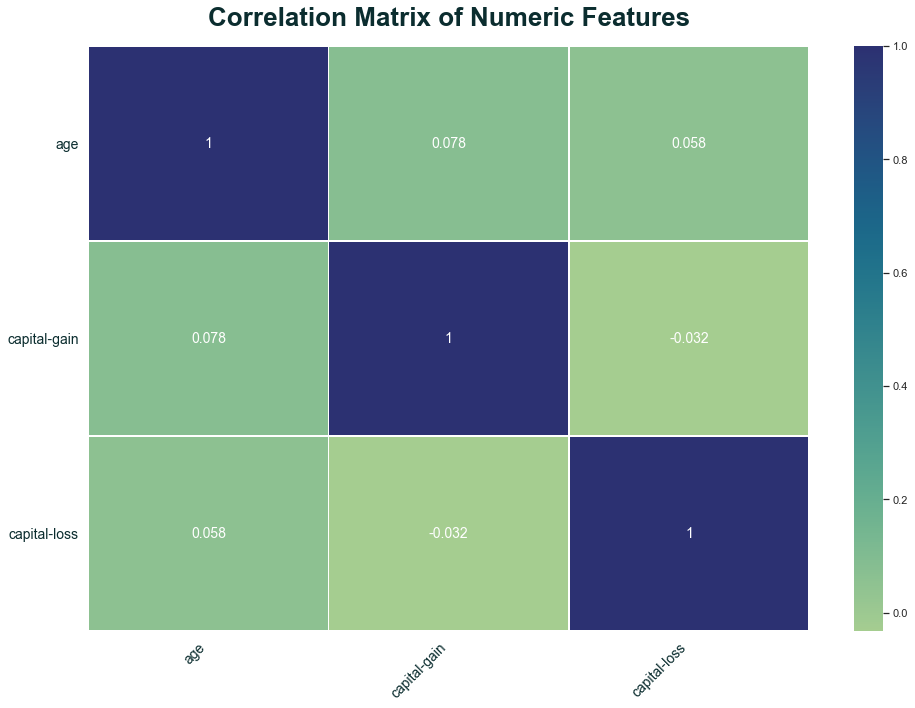

In [83]:
#OHE for numeric features only

# Select numeric columns only
#numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])
numeric_df = train_df_mode.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10))

ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="crest",             
    linewidths=0.6,
    linecolor="white",
    annot_kws={"fontsize": 14, "color": "white"}  
)

plt.title(
    "Correlation Matrix of Numeric Features",
    fontsize=26,
    fontweight="bold",
    color="#0B2D2F",
    pad=20
)

plt.xticks(
    fontsize=14,
    rotation=45,
    ha="right",
    color="#0B2D2F"
)

plt.yticks(
    fontsize=14,
    rotation=0,
    color="#0B2D2F"
)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

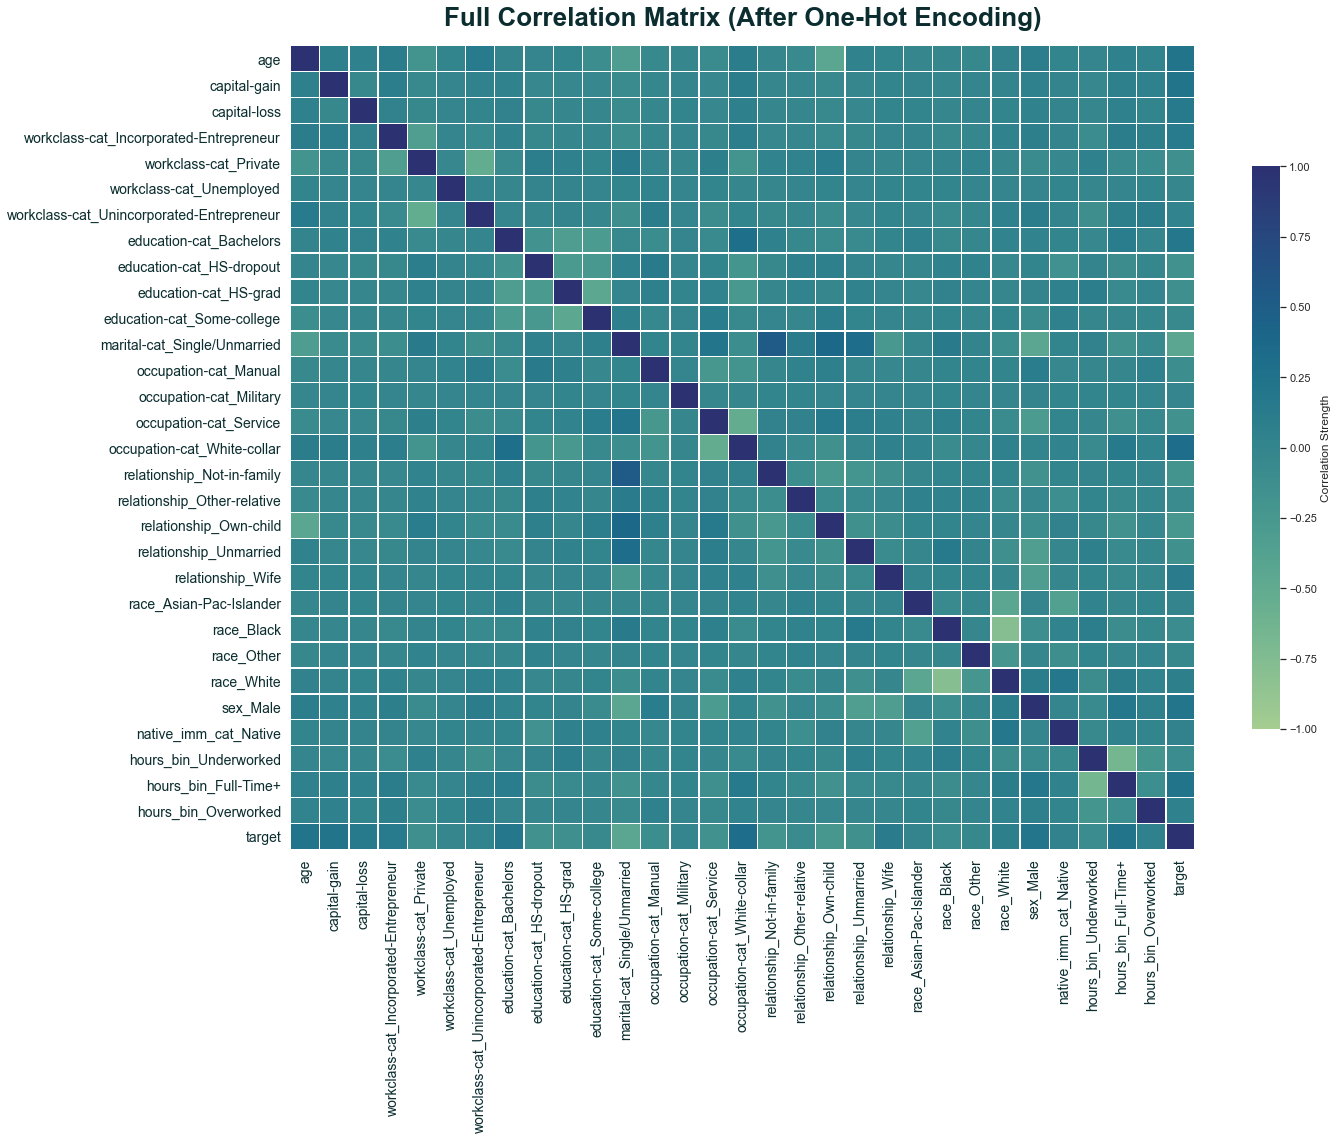

In [75]:
#OHE for correlation matrix

# One-hot encode categorical features
#encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)
encoded_df = pd.get_dummies(train_df_mode.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
#encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)
encoded_df['target'] = train_df_mode['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(20, 16))

ax = sns.heatmap(
    corr,
    cmap='crest',            
    vmin=-1, vmax=1,
    linewidths=0.3,
    linecolor='white',
    cbar_kws={
        "shrink": 0.7,
        "label": "Correlation Strength"
    }
)

plt.title(
    "Full Correlation Matrix (After One-Hot Encoding)",
    fontsize=26,
    fontweight='bold',
    color="#0B2D2F",
    pad=20
)

plt.xticks(
    fontsize=14,
    rotation=90,
    color="#0B2D2F"
)

plt.yticks(
    fontsize=14,
    rotation=0,
    color="#0B2D2F"
)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [87]:
# Convert pred to binary
#binary_corr_df = train_df.copy()
binary_corr_df = train_df_mode.copy()
binary_corr_df['target'] = binary_corr_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(binary_corr_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                                       1.000000
marital-cat_Married                          0.445202
relationship_Husband                         0.400941
occupation-cat_White-collar                  0.305514
education-cat_Advanced-degree                0.269111
age                                          0.234037
hours_bin_Full-Time+                         0.231183
capital-gain                                 0.223336
sex_Male                                     0.215969
education-cat_Bachelors                      0.180535
capital-loss                                 0.150501
workclass-cat_Incorporated-Entrepreneur      0.139446
relationship_Wife                            0.123230
race_White                                   0.085235
workclass-cat_Government                     0.061812
hours_bin_Overworked                         0.054071
native_imm_cat_Native                        0.038702
workclass-cat_Unincorporated-Entrepreneur    0.030017
race_Asian-Pac-Islander     

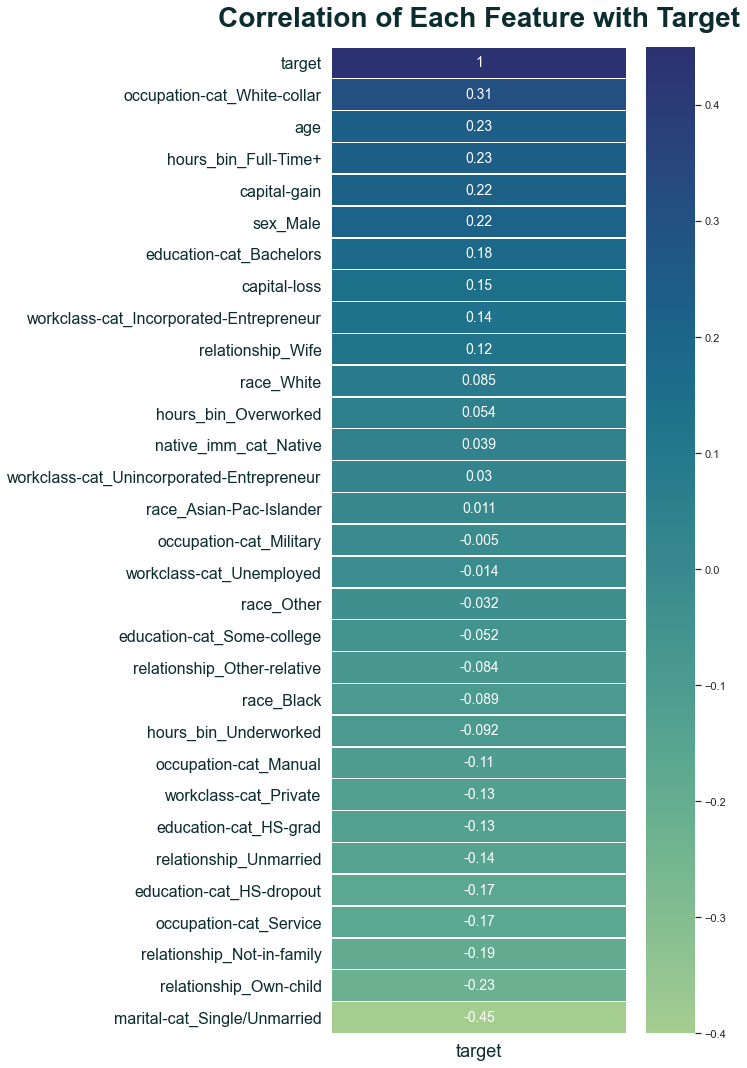

In [78]:
plt.figure(figsize=(10, 15))

ax = sns.heatmap(
    corr_target.to_frame(),
    annot=True,
    cmap='crest',
    vmin=-0.4,
    vmax=0.45,
    linewidths=0.5,
    annot_kws={"fontsize": 14, "color": "white"}  # bigger, darker numbers
)

plt.xticks(fontsize=18, rotation=0, color="#0B2D2F")
plt.yticks(fontsize=16, rotation=0, color="#0B2D2F")

plt.title(
    "Correlation of Each Feature with Target",
    fontsize=28,
    fontweight='bold',
    color="#0B2D2F",
    pad=20
)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [79]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(binary_corr_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)

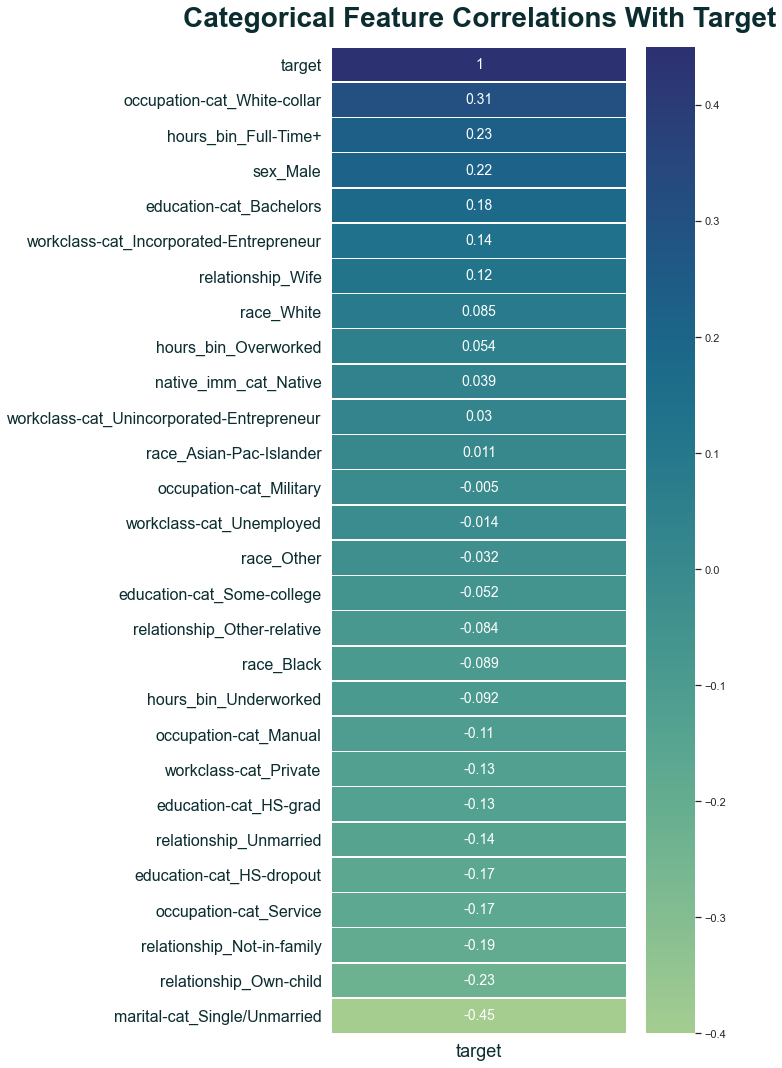

In [80]:
plt.figure(figsize=(10, 15))

ax = sns.heatmap(
    corr_target_only.to_frame(),
    annot=True,
    cmap='crest',
    vmin=-0.4,
    vmax=0.45,
    linewidths=0.5,
    annot_kws={"fontsize": 14, "color": "white"}  # bigger, darker numbers
)

plt.xticks(fontsize=18, rotation=0, color="#0B2D2F")
plt.yticks(fontsize=16, rotation=0, color="#0B2D2F")

plt.title(
    "Categorical Feature Correlations With Target",
    fontsize=28,
    fontweight='bold',
    color="#0B2D2F",
    pad=20
)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [81]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

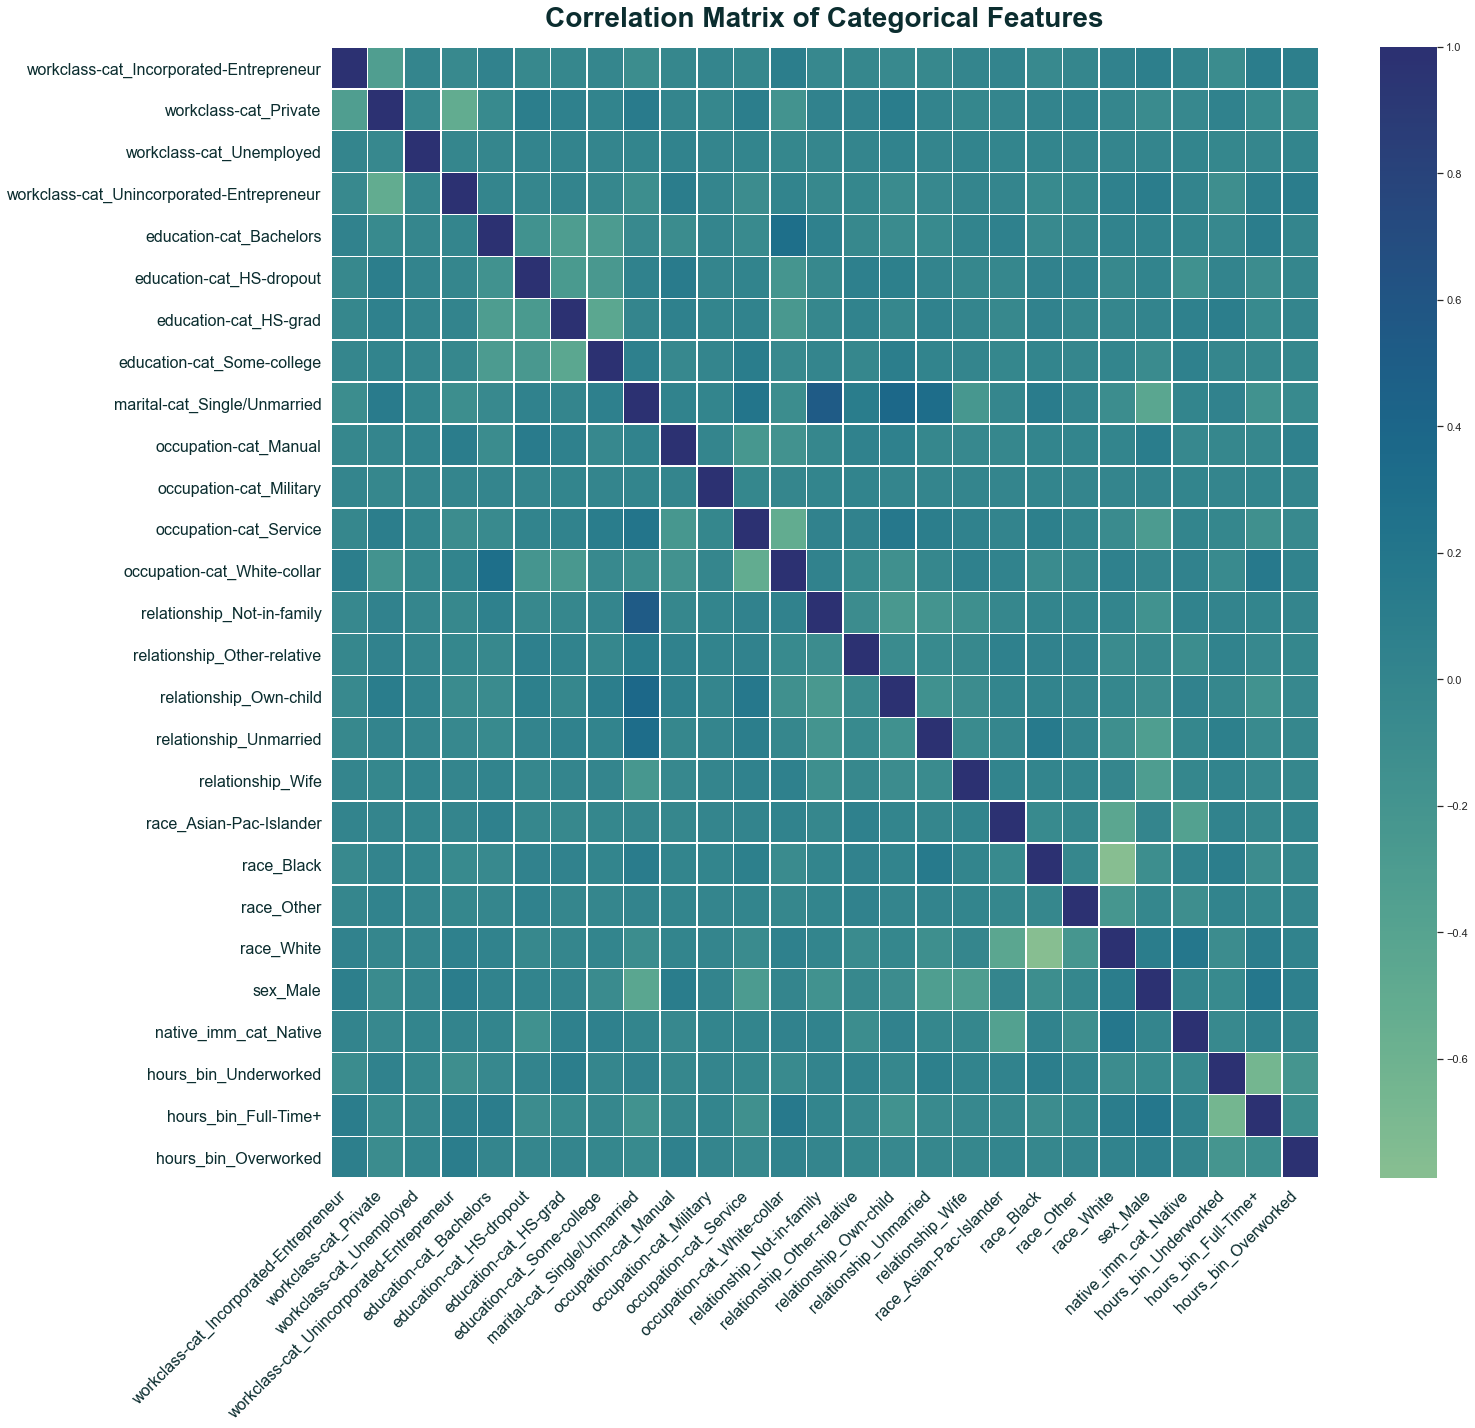

In [82]:
plt.figure(figsize=(22, 20))

ax = sns.heatmap(
    cat_corr_matrix,
    cmap='crest',
    center=0,
    linewidths=0.5
)

plt.xticks(fontsize=16, rotation=45, ha="right", color="#0B2D2F")  # dark teal labels
plt.yticks(fontsize=16, rotation=0, color="#0B2D2F")

plt.title(
    "Correlation Matrix of Categorical Features",
    fontsize=28,
    fontweight='bold',
    color="#0B2D2F",
    pad=20
)

plt.tight_layout()
plt.show()